In [2]:
from __future__ import absolute_import, print_function, unicode_literals
from builtins import dict, str
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from indra import trips
from indra.assemblers import PysbAssembler
from indra.util.plot_formatting import *
from pysb import Observable, Parameter
from pysb.integrate import Solver
from pysb.export import export

INFO: indra/elsevier - No Elsevier institution key found in environment variable ELSEVIER_INST_KEY.


In [3]:
def add_observable(model):
    # Add active p53 observable
    p53 = model.monomers['TP53']
    obs = Observable('p53_active', p53(activity='active'))
    model.add_component(obs)

In [5]:
def set_parameters(model):
    if model.name.startswith('ATM'):
        atm_atr = 'ATM'
    else:
        atm_atr = 'ATR'

    # Set activation parameters to 1e-7
    for param in model.parameters:
        if param.name.startswith('kf') and param.name.find('act') != -1:
            param.value = 1e-7

    # Update Wip1 -| p53 parameter
    model.parameters['kf_pt_act_1'].value = 5e-7

    # Update the Wip1 -| ATM parameter in ATM models
    if atm_atr == 'ATM':
        if not (model.name.endswith('v4a') or model.name.endswith('v4b')):
            model.parameters['kf_pa_act_1'].value = 1e-5
        else:
            model.parameters['kf_pa_dephosphorylation_1'].value = 1e-5

    # Update ATR/ATM autoactivation parameter in v3/v4 models
    if model.name.endswith('v3'):
        model.parameters['kf_aa_act_1'].value = 5e-7
    elif model.name.endswith('v4a'):
        model.parameters['kf_a_autophos_1'].value = 5e-7
    elif model.name.endswith('v4b'):
        model.parameters['kf_aa_phosphorylation_1'].value = 5e-7

    # Set some of the transcription/degradation parameters in v4 models:
    if model.name.startswith('ATM_v4'):
        model.parameters['MDM2_0'].value = 0
        model.parameters['kf_m_deg_1'].value = 8e-2
        model.parameters['kf_tm_synth_1'].value = 2e-2

    # Start with some initial active/phosphorylated ATR/ATM
    model.add_component(Parameter('%sa_0' % atm_atr, 1))
    atm_atr_m = model.monomers[atm_atr]
    if not model.name.startswith('ATM_v4'):
        model.initial(atm_atr_m(activity='active'),
                      model.parameters['%sa_0' % atm_atr])
    else:
        model.initial(atm_atr_m(phospho='p'),
                      model.parameters['%sa_0' % atm_atr])

In [6]:
def assemble_model(model_name, reread=False):
    xml_fname = model_name + '.xml'
    if not reread:
        print('Processing %s' % xml_fname)
        if os.path.exists(xml_fname):
            with open(xml_fname, 'rb') as fh:
                tp = trips.process_xml(fh.read())
        else:
            reread = True
    if reread:
        fname = model_name + '.txt'
        print('Reading %s' % fname)
        with open(fname, 'rb') as fh:
            ts = time.time()
            tp = trips.process_text(fh.read(), xml_fname)
            te = time.time()
            print('Reading took %.2fs' % (te-ts))
    print('Assembling statements:')
    for i, st in enumerate(tp.statements):
        print('%d: %s' % (i, st))
    print('----------------------')

    pa = PysbAssembler()
    pa.add_statements(tp.statements)
    ts = time.time()
    model = pa.make_model()
    te = time.time()
    print('Assembly took %.2fs' % (te-ts))
    model.name = model_name

    add_observable(model)
    set_parameters(model)

    # Save and return model
    pa.model = model
    pa.save_model('%s.py' % model_name)
    return model

In [7]:
def run_model(model):
    sim_hours = 20
    ts = np.linspace(0, sim_hours*3600, sim_hours*60)
    tst = time.time()
    solver = Solver(model, ts)
    solver.run()
    te = time.time()
    print('Simulation took %.2fs' % (te-tst))
    plt.figure(figsize=(1.8, 1), dpi=300)
    set_fig_params()
    plt.plot(ts, solver.yobs['p53_active'], 'r')
    plt.xticks([])
    plt.xlabel('Time (a.u.)', fontsize=7)
    plt.ylabel('Active p53', fontsize=7)
    plt.yticks([])
    ax = plt.gca()
    format_axis(ax)
    #plt.subplots_adjust()
    plt.savefig(model.name + '.pdf')
    return ts, solver

In [8]:
def export_pomi(model, formats):
    for f in formats:
        model_export = export(model, f)
        extension = (f if f != 'pysb_flat' else 'py')
        fname = 'POMI1.0.%s' % extension
        with open(fname, 'wb') as fh:
            fh.write(model_export)

In [10]:
%matplotlib inline

Processing ATR_v1.xml
Reading ATR_v1.txt
Reading took 7.87s
Assembling statements:
0: Activation(ATR(activity: True), TP53())
1: Activation(TP53(activity: True), PPM1D())
2: Activation(TP53(activity: True), MDM2())
3: Inhibition(PPM1D(activity: True), TP53())
4: Inhibition(MDM2(activity: True), TP53())
----------------------
Assembly took 0.01s
Simulation took 0.30s
Processing ATR_v2.xml
Reading ATR_v2.txt
Reading took 11.20s
Assembling statements:
0: Activation(ATR(activity: True), TP53())
1: Activation(TP53(activity: True), PPM1D())
2: Activation(TP53(activity: True), MDM2())
3: Inhibition(PPM1D(activity: True), TP53())
4: Inhibition(MDM2(activity: True), TP53())
5: Inhibition(HIPK2(), PPM1D())
6: Inhibition(CDKN2A(), MDM2())
----------------------
Assembly took 0.01s
Simulation took 0.36s
Processing ATR_v3.xml
Reading ATR_v3.txt
Reading took 14.22s
Assembling statements:
0: Activation(ATR(activity: True), TP53())
1: Activation(TP53(activity: True), PPM1D())
2: Activation(TP53(activi

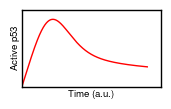

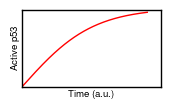

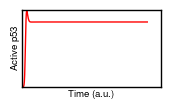

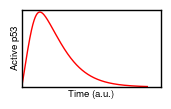

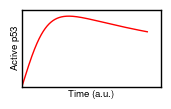

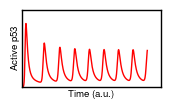

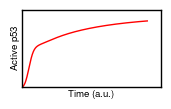

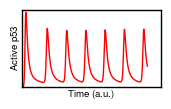

In [11]:
if __name__ == '__main__':
    reread = False
    model_names = ['ATR_v1',
                   'ATR_v2',
                   'ATR_v3',
                   'ATM_v1',
                   'ATM_v2',
                   'ATM_v3',
                   'ATM_v4a',
                   'ATM_v4b']
    for model_name in model_names:
        model = assemble_model(model_name, reread=reread)
        ts, solver = run_model(model)
        if model_name == 'ATM_v4b':
            formats = ['sbml', 'bngl', 'kappa', 'pysb_flat']
            export_pomi(model, formats)